In [1]:
%matplotlib inline
import glob
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

from astropy.table import Table

from astropy.utils.exceptions import AstropyWarning
import warnings
    
np.seterr(all='ignore')
warnings.simplefilter('ignore', category=AstropyWarning)

# https://github.com/gbrammer/eazy-py
import eazy

In [2]:
#add stuff to path

import sys
# the mock-0.3.1 dir contains testcase.py, testutils.py & mock.py
sys.path.append('/work/03565/stevans/maverick/my_projects/decam/code')
sys.path.append('..')

In [3]:
#newfirm data measurements
nhs_path = '/work/03565/stevans/maverick/my_projects/psfex_on_stack/data/processed/combined/cat_v03.fits'
nhs = Table.read(nhs_path)


In [4]:
#table with fluxes from all bands passed to eazypy
cat_new = Table.read('../data/interim/C3.flux.vista.irac_trac.decam.fits')

In [5]:
# Galactic extinction
EBV = {'aegis':0.0066, 'cosmos':0.0148, 'goodss':0.0069, 'uds':0.0195, 'goodsn':0.0103}['goodss']
    
#roots = ['../data/raw/CANDELS_GDSS_workshop', '../data/raw/CANDELS_GDSS_workshop_z1'][:1]
roots = ['../data/interim/C3', '../data/raw/CANDELS_GDSS_workshop_z1'][:1]

for root in roots:
    print('\n####\n')
    params = {}

    params['CATALOG_FILE'] = '{0}.flux.vista.irac_trac.decam.fits'.format(root)
    params['MAIN_OUTPUT_FILE'] = '{0}.vista.irac_trac.decam.eazypy'.format(root)

    params['PRIOR_FILTER'] = 205
    params['PRIOR_ABZP'] = 25
    params['MW_EBV'] = EBV

    params['Z_MAX'] = 12
    params['Z_STEP'] = 0.01

    params['TEMPLATES_FILE'] = 'templates/fsps_full/tweak_fsps_QSF_12_v3.param'
    
    params['VERBOSITY'] = 1
    
    ez = eazy.photoz.PhotoZ(param_file=None,
                              translate_file='../data/interim/zphot.translate.shela',
                              zeropoint_file=None, params=params,
                              load_prior=False, load_products=True, n_proc=-1)


####

Read default param file: /work/03565/stevans/maverick/software/anaconda3/envs/eazypy/lib/python3.5/site-packages/eazy/data/zphot.param.default
Read CATALOG_FILE: ../data/interim/C3.flux.vista.irac_trac.decam.fits
flux_u err_u (293): DECam/DECam_u.txt
flux_g err_g (294): DECam/DECam_g.txt
flux_r err_r (295): DECam/DECam_r.txt
flux_i err_i (296): DECam/DECam_i.txt
flux_z err_z (297): DECam/DECam_z.txt
flux_K err_K (134): NEWFIRM/k_atmos.dat
flux_K_vista err_K_vista (259): VISTA/Ks_system+atmos.dat
flux_J_vista err_J_vista (257): VISTA/J_system+atmos.dat
flux_ch1 err_ch1 ( 18): IRAC/irac_tr1_2004-08-09.dat
flux_ch2 err_ch2 ( 19): IRAC/irac_tr2_2004-08-09.dat


/work/03565/stevans/maverick/software/anaconda3/envs/eazypy/lib/python3.5/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/work/03565/stevans/maverick/software/anaconda3/envs/eazypy/lib/python3.5/site-packages/pysynphot/locations.py:329: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


Process template tweak_fsps_QSF_12_v3_001.dat.
Process template tweak_fsps_QSF_12_v3_002.dat.
Process template tweak_fsps_QSF_12_v3_003.dat.
Process template tweak_fsps_QSF_12_v3_004.dat.
Process template tweak_fsps_QSF_12_v3_005.dat.
Process template tweak_fsps_QSF_12_v3_006.dat.
Process template tweak_fsps_QSF_12_v3_007.dat.
Process template tweak_fsps_QSF_12_v3_008.dat.
Process template tweak_fsps_QSF_12_v3_009.dat.
Process template tweak_fsps_QSF_12_v3_010.dat.
Process template tweak_fsps_QSF_12_v3_011.dat.
Process template tweak_fsps_QSF_12_v3_012.dat.
Process templates: 25.715 s
Load products: ../data/interim/C3.vista.irac_trac.decam.eazypy.zout.fits
`error_residuals`: force uncertainties to match residuals
`error_residuals`: force uncertainties to match residuals


In [6]:
zout = Table.read('{0}.zout.fits'.format(params['MAIN_OUTPUT_FILE']))
zout['ssfr'] = zout['SFR']/zout['mass']
print(zout.colnames)

['id', 'z_spec', 'nusefilt', 'numpeaks', 'z_phot', 'z_phot_chi2', 'z_phot_risk', 'z_min_risk', 'min_risk', 'z_chi2_noprior', 'chi2_noprior', 'z025', 'z160', 'z500', 'z840', 'z975', 'restU', 'restU_err', 'restB', 'restB_err', 'restV', 'restV_err', 'restJ', 'restJ_err', 'Lv', 'MLv', 'Av', 'mass', 'SFR', 'LIR', 'line_flux_Ha', 'line_EW_Ha', 'line_flux_O3', 'line_EW_O3', 'line_flux_Hb', 'line_EW_Hb', 'line_flux_O2', 'line_EW_O2', 'line_flux_Lya', 'line_EW_Lya', 'ssfr']


In [7]:
#make a cut so we can make cuts from the original but keep zout for plotting:
zout_copy = zout.copy()

In [8]:
#make a S/N cut
mask_k = cat_new['flux_K']/cat_new['err_K'] > 5

In [9]:
#remove bright stars:
#let's not remove them by flux v size b/c EAZy should remove them by color.
import sys
sys.path.append('/work/03565/stevans/maverick/my_projects')
mask_field = nhs['FIELD_A'] == 'C3'
dat = nhs[mask_field]

field = 'C3'
import psfex_on_stack.src.star_selection.define_field_para_copy as dfp
cut,ylimit = dfp.now(field, '-PS', '-post-inspect')
#print("parameter cuts: ", cut)
mask_stars = ((np.log10(abs(dat['FLUX_AUTO_corrected_nJy_best'])) > 4.7)
#& (np.log10(abs(dat['FLUX_APER'])) > cut[1]) 
& (dat['FLUX_RADIUS'] < cut[2]) 
& (dat['IMAFLAGS_ISO'] == 0)
& (dat['FLUX_RADIUS'] > cut[3]))

define_field_para.py ran.


In [10]:
#make redishft mask
mask_z = (zout_copy['z_phot'] > 3) & (zout_copy['z_phot'] < 5)

In [11]:
#apply cuts:
zout = zout_copy[mask_k & mask_z]

In [12]:
print(len(zout_copy), len(zout))

15407 1498


In [13]:
### UVJ
uv = -2.5*np.log10(zout['restU']/zout['restV'])
vj = -2.5*np.log10(zout['restV']/zout['restJ'])

uverr = 2.5*np.sqrt((zout['restU_err']/zout['restU'])**2+(zout['restV_err']/zout['restV'])**2)
vjerr = 2.5*np.sqrt((zout['restV_err']/zout['restV'])**2+(zout['restJ_err']/zout['restJ'])**2)

/work/03565/stevans/maverick/software/anaconda3/envs/eazypy/lib/python3.5/site-packages/numpy/core/numeric.py:531: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/work/03565/stevans/maverick/software/anaconda3/envs/eazypy/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


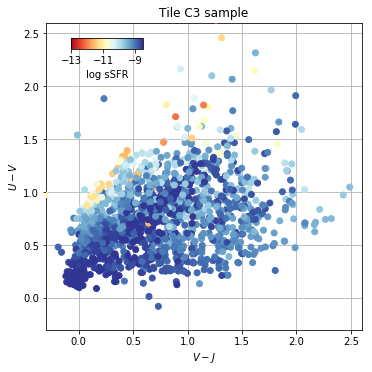

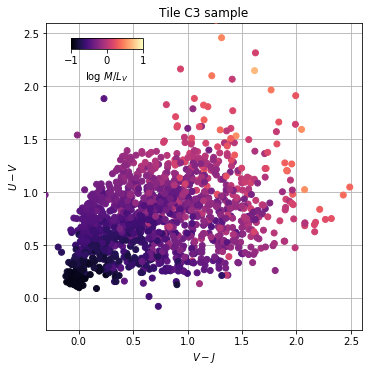

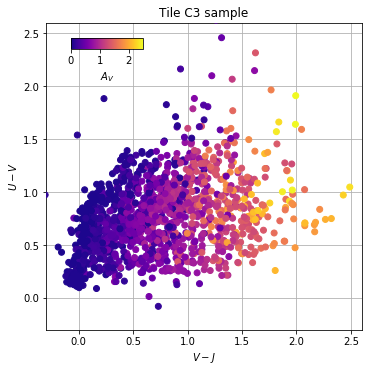

In [53]:
for show in ['ssfr', 'MLv', 'Av']:
    
    fig = plt.figure(figsize=[5,5])
    
    ax = fig.add_subplot(111)
    ax.errorbar(vj, uv, xerr=0, yerr=0, color='k', 
                alpha=0.1, marker='.', capsize=0, linestyle='None')
    
    if show == 'ssfr':
        sc = ax.scatter(vj, uv, c=np.log10(zout['ssfr']), 
                        vmin=-13, vmax=-8.5, zorder=10, cmap='RdYlBu')
        label = 'log sSFR'
        ticks = np.arange(-13,-8,2)
    
    elif show == 'MLv':
        sc = ax.scatter(vj, uv, c=np.log10(zout['MLv']), 
                        vmin=-1, vmax=1, zorder=10, cmap='magma')
        label = r'$\log\ M/L_V$'
        ticks = np.arange(-1,1.1,1)

    elif show == 'Av':
        sc = ax.scatter(vj, uv, c=zout['Av'], vmin=0, 
                        vmax=2.5, zorder=10, cmap='plasma')
        label = r'$A_V$'
        ticks = np.arange(0,2.1,1)
    
    # Colorbar
    cax = fig.add_axes((0.18, 0.88, 0.2, 0.03))
    cb = plt.colorbar(sc, cax=cax, orientation='horizontal')
    cb.set_label(label)
    cb.set_ticks(ticks)
    
    ax.set_xlim(-0.3, 2.6)
    ax.set_ylim(-0.3, 2.6)
    
    ax.grid()
    
    ax.set_xlabel(r'$V-J$'); ax.set_ylabel(r'$U-V$')
    ax.set_title('Tile C3 sample')
    
    fig.tight_layout(pad=0.1)
    
    #plt.savefig('Riverside_z1_{0}.pdf'.format(show))

In [15]:
mask_ssfr = np.log10(zout_copy['ssfr']) < -11
#mask_ssfr = (np.log10(zout_copy['ssfr']) > -11) & (np.log10(zout_copy['ssfr']) < -10)
mask_z = (zout_copy['z_phot'] > 3) & (zout_copy['z_phot'] < 5)

In [16]:
mask_inspect = mask_ssfr & mask_k & mask_z

106847


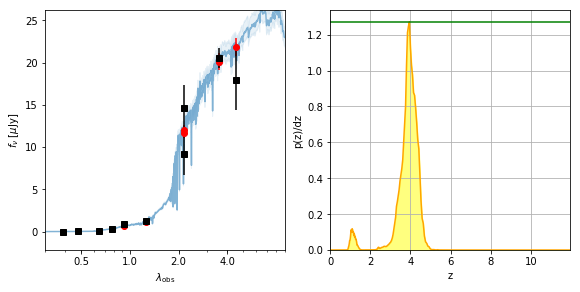

In [17]:
# Show SED
for id_i in ez.cat['id'][mask_inspect][0:1]:
    print(id_i)
    fig = ez.show_fit(id_i, show_fnu=1)


In [18]:
import astropy.io.fits as fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy import wcs

load_sci_images_first = True
    
if load_sci_images_first:
	decam_sci_imgs = {}
	decam_sci_imgs['scidata'] = {}
	decam_sci_imgs['header'] = {}
	decam_sci_imgs['w'] = {}
	#read into memory all sci images 
	fields = np.arange(4)+3
	for field in fields:
		for band in ['u','g','r','i','z']:

			image_now = '/work/03229/iwold/maverick/fall_field/stack/v2/psf/nano/B'+ \
            str(field)+'_'+band+'_psfsci.fits'
            
			f = fits.open(image_now)
			decam_sci_imgs['scidata'][str(field)+band] = f[0].data
			decam_sci_imgs['header'][str(field)+band] = f[0].header
			decam_sci_imgs['w'][str(field)+band] = wcs.WCS(f[0].header)


In [19]:
#load K images into memory

fields = np.arange(1,28,1).astype('str')
fields = ['A'+field for field in fields]

fieldsB = np.arange(1,29,1).astype('str')
fieldsB = ['B'+field for field in fieldsB]

fieldsC = np.arange(1,29,1).astype('str')
fieldsC = ['C'+field for field in fieldsC]

fieldsD = np.arange(1,17,1).astype('str')
fieldsD2 = np.array(['2.3','2.7','4.3','4.7','6.3','6.7','8.3','8.7','10.3','10.7'])
fieldsD = np.append(fieldsD,fieldsD2)
fieldsD = ["D"+field2 for field2 in fieldsD]


fields.extend(fieldsB)
fields.extend(fieldsC)
fields.extend(fieldsD)

nhs_sci_imgs = {}
nhs_sci_imgs['scidata'] = {}
nhs_sci_imgs['header'] = {}
nhs_sci_imgs['w'] = {}
for nhs_field in fields:
    image_now = img_path = '/work/03565/stevans/maverick/my_projects/'+\
    'psfex_on_stack/data/raw/'+nhs_field+'_data.fits'


    f = fits.open(image_now)
    nhs_sci_imgs['scidata'][nhs_field] = f[0].data
    nhs_sci_imgs['header'][nhs_field] = f[0].header
    nhs_sci_imgs['w'][nhs_field] = wcs.WCS(f[0].header)


In [20]:
#load irac images into memory
irac_sci_imgs = {}
irac_sci_imgs['scidata'] = {}
irac_sci_imgs['header'] = {}
irac_sci_imgs['w'] = {}
for band in ['ch1','ch2']:
    if band == 'ch1':
        image_now = '/work/03564/stevenf/maverick/SHELA/Imaging/IRAC/ch1s_wavg.fits'
    if band == 'ch2':
        image_now = '/work/03564/stevenf/maverick/SHELA/Imaging/IRAC/ch2s_wavg.fits'

    f = fits.open(image_now)
    irac_sci_imgs['scidata'][band] = f[0].data
    irac_sci_imgs['header'][band] = f[0].header
    irac_sci_imgs['w'][band] = wcs.WCS(f[0].header)


In [21]:
import src.images.cutout2D_wrapper as c2D

In [22]:
from psfex_on_stack.src.field_coords import get_img_cen
from importlib import reload
reload(get_img_cen)
fields, cens = get_img_cen.get_img_cen()

In [23]:
ra = nhs['RA'][id_i]
dec = nhs['DEC'][id_i]

In [39]:
def get_stamps(ra,dec):

    #get newfirm field
    from psfex_on_stack.src.field_coords import get_img_cen
    from importlib import reload
    reload(get_img_cen)
    fields, cens = get_img_cen.get_img_cen()

    #match ra and dec to field center
    c = SkyCoord(ra=[ra]*u.degree, dec=[dec]*u.degree)
    catalog = SkyCoord(ra=cens[:,0]*u.degree, dec=cens[:,1]*u.degree)

    idx, d2d, d3d = catalog.match_to_catalog_sky(c)

    id_order = np.argsort(d2d)

    id_best = id_order[0]

    nhs_field = fields[id_best]


    if ra < 16.902788:
        field = 3
    else:
        if ra < 19.701404:
            field = 4
        else:
            if ra < 22.499992:
                field = 5
            else:
                field = 6


    bands = ['u','g','r','i','z','K','ch1','ch2']
    stamps_obj = {}

    stamp_lens = [30.,20.,5.]
    stamps_reg_len = {stamp_lens[0]:str(7.*0.27),stamp_lens[1]:str(3.5*0.27)} #7 pixels is in the sex files and is diam of aper
    for stamp_len in stamp_lens:
        stamps_obj[stamp_len] = {}
    grid_size_out = {}


    for band in bands:

        image_now = '/work/03565/stevans/maverick/working/decam/psfmatched2017/per_field/v1.0/SHELA'+str(field)+'_'+band+'_con.fits'

        if band == 'ch1':
            image_now = '/work/03564/stevenf/maverick/SHELA/Imaging/IRAC/ch1s_wavg.fits'
        if band == 'ch2':
            image_now = '/work/03564/stevenf/maverick/SHELA/Imaging/IRAC/ch2s_wavg.fits'
        flux_scale = 1.
        if band[0] == 'c':
            flux_scale = 1000.

        if load_sci_images_first:
            if band in ['u','g','r','i','z']:
                data_now = {}
                data_now['scidata'] = decam_sci_imgs['scidata'][str(field)+band]
                data_now['header'] = decam_sci_imgs['header'][str(field)+band]
                data_now['w'] = decam_sci_imgs['w'][str(field)+band]
            else:
                if band in ['ch1','ch2']:
                    data_now = {}
                    data_now['scidata'] = irac_sci_imgs['scidata'][band]
                    data_now['header'] = irac_sci_imgs['header'][band]
                    data_now['w'] = irac_sci_imgs['w'][band]
                else:
                    if band in ['K']:
                        data_now = {}
                        data_now['scidata'] = nhs_sci_imgs['scidata'][nhs_field]
                        data_now['header'] = nhs_sci_imgs['header'][nhs_field]
                        data_now['w'] = nhs_sci_imgs['w'][nhs_field]
        else:
            data_now = False

        for stamp_len in stamp_lens:
            #if stamp_len == 30.:
            #    stamps_obj[stamp_len][band] = c2D.now(image_now, ra, dec, stamp_len, data_now = data_now, save_to_file = None) #, save_to_file = '/work/03565/stevans/maverick/my_projects/decam/shared/decam_u_proposal_stamps/'+band+'.fits')
            #else:
            #    if band[0] == 'c':
            #        stamps_obj[stamp_len][band] = c2D.now(image_now, ra, dec, stamp_len, data_now = data_now, save_to_file = None)
            #    else:
            stamps_obj[stamp_len][band] = c2D.now(image_now, ra, dec, stamp_len, data_now = data_now, save_to_file = None)
            stamps_obj[stamp_len][band].data = stamps_obj[stamp_len][band].data * flux_scale

    return stamps_obj


In [40]:
stamps_obj = get_stamps(ra,dec)

In [41]:
import get_zscale_range as gzr
reload(gzr)

<module 'get_zscale_range' from '/work/03565/stevans/maverick/my_projects/decam/code/get_zscale_range.py'>

In [42]:
stamps_obj

{5.0: {'K': <astropy.nddata.utils.Cutout2D at 0x2b6266596ba8>,
  'ch1': <astropy.nddata.utils.Cutout2D at 0x2b626658a3c8>,
  'ch2': <astropy.nddata.utils.Cutout2D at 0x2b62665a44e0>,
  'g': <astropy.nddata.utils.Cutout2D at 0x2b626655e5f8>,
  'i': <astropy.nddata.utils.Cutout2D at 0x2b626657b518>,
  'r': <astropy.nddata.utils.Cutout2D at 0x2b626656c080>,
  'u': <astropy.nddata.utils.Cutout2D at 0x2b626586ccc0>,
  'z': <astropy.nddata.utils.Cutout2D at 0x2b626657f390>},
 20.0: {'K': <astropy.nddata.utils.Cutout2D at 0x2b6266596390>,
  'ch1': <astropy.nddata.utils.Cutout2D at 0x2b62665adc18>,
  'ch2': <astropy.nddata.utils.Cutout2D at 0x2b62665a45c0>,
  'g': <astropy.nddata.utils.Cutout2D at 0x2b6266565898>,
  'i': <astropy.nddata.utils.Cutout2D at 0x2b626657f9b0>,
  'r': <astropy.nddata.utils.Cutout2D at 0x2b626656cf28>,
  'u': <astropy.nddata.utils.Cutout2D at 0x2b62646c8d68>,
  'z': <astropy.nddata.utils.Cutout2D at 0x2b626656cdd8>},
 30.0: {'K': <astropy.nddata.utils.Cutout2D at 0x2b

In [49]:
stamps_obj = {}
for id_i in ez.cat['id'][mask_inspect]:
    print(id_i)
    
    ra = nhs['RA'][id_i]
    dec = nhs['DEC'][id_i]
    stamps_obj[id_i] = get_stamps(ra,dec)

106847
106966
107005
107009
107953
108206
108431
108624
108839
109957
110440
110474
110885
111666
112194
112294
112920
113172
113999
114051
114310
114825
114850
115213
115237
115789
116406
117758
118142
118441
118572
118772
118925
118941
120544
120901
121595


106847
    z_phot   
-------------
3.93511069585
    mass    
  solMass   
------------
11.734809312
     SFR     
 solMass / yr
-------------
1.40772085645
       ssfr      
-----------------
2.59243116129e-12
106966
    z_phot   
-------------
4.05984171126
    mass   
  solMass  
-----------
10.80961436
     SFR      
 solMass / yr 
--------------
0.503376219113
      ssfr      
----------------
7.8033005508e-12
107005
    z_phot   
-------------
4.41875489144
     mass    
   solMass   
-------------
11.6288035083
     SFR     
 solMass / yr
-------------
1.87740327763
       ssfr      
-----------------
4.41320461319e-12
107009
    z_phot   
-------------
4.54285274685
     mass    
   solMass   
-------------
11.1539341549
     SFR     
 solMass / yr
-------------
1.05645326905
       ssfr      
-----------------
7.41167105915e-12
107953
    z_phot   
-------------
3.68247339462
     mass    
   solMass   
-------------
11.1104236189
     SFR     
 solMass / yr
-------------
0.33

/work/03565/stevans/maverick/software/anaconda3/envs/eazypy/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


108624
   z_phot   
------------
3.3919847972
     mass    
   solMass   
-------------
10.5726574701
     SFR     
 solMass / yr
-------------
0.14513218284
       ssfr      
-----------------
3.88245344885e-12
108839
    z_phot   
-------------
4.67629711734
     mass    
   solMass   
-------------
11.4512236397
     SFR     
 solMass / yr
-------------
0.60024420236
       ssfr      
-----------------
2.12375460865e-12
109957
    z_phot   
-------------
3.98476627496
     mass    
   solMass   
-------------
11.4854021387
     SFR     
 solMass / yr
-------------
1.54353810025
       ssfr      
-----------------
5.04795198419e-12


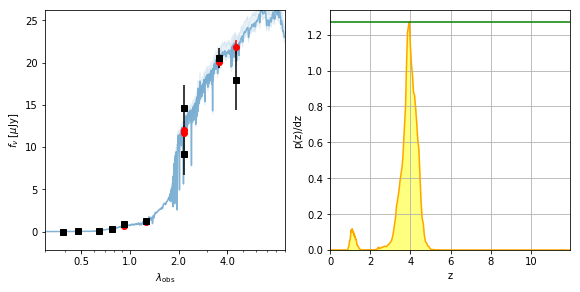

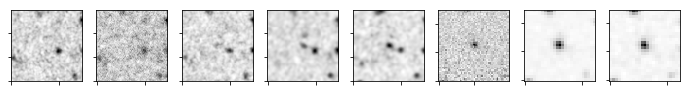

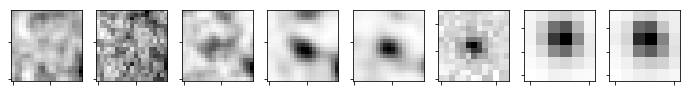

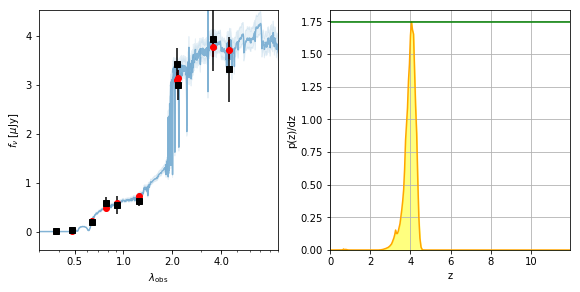

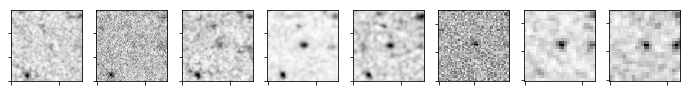

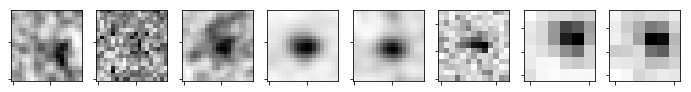

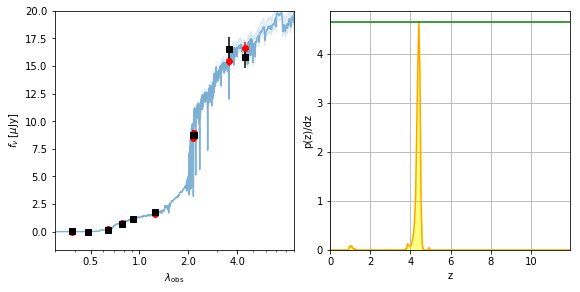

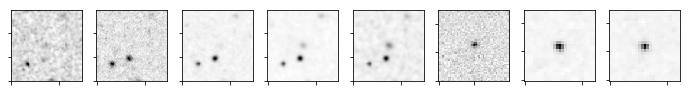

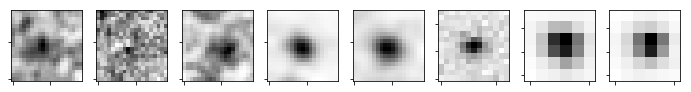

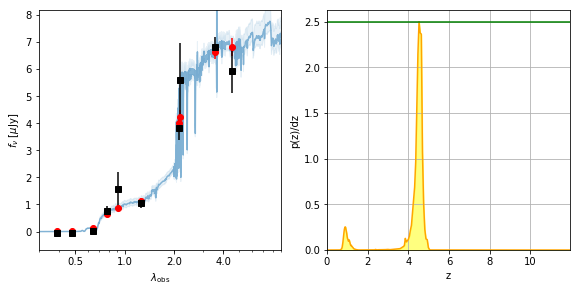

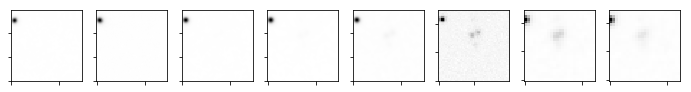

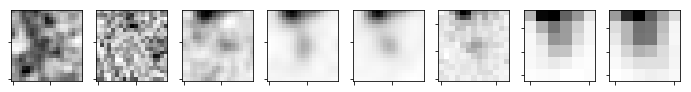

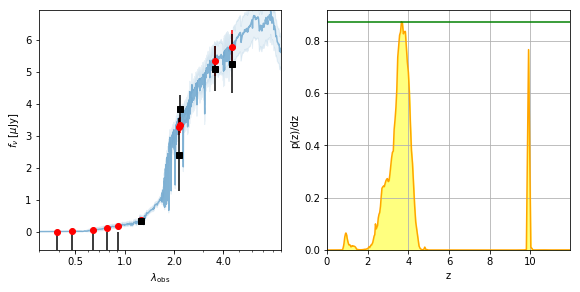

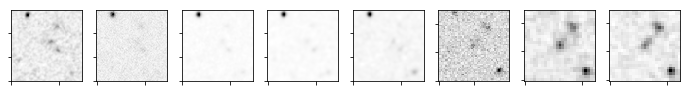

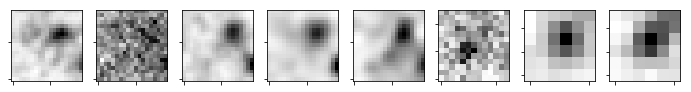

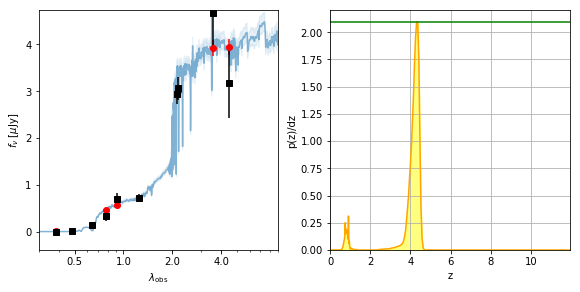

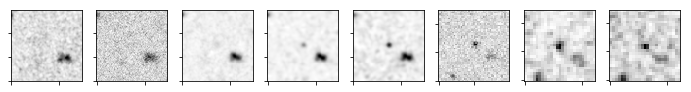

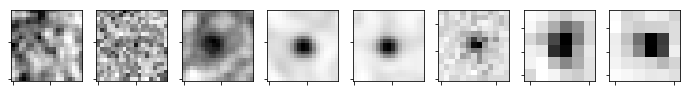

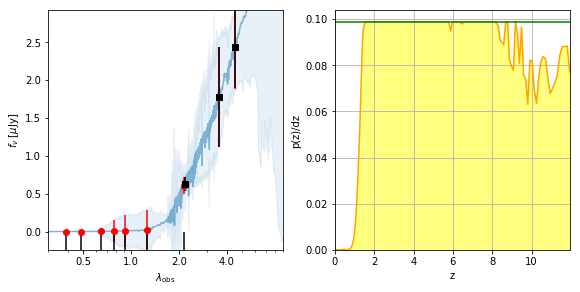

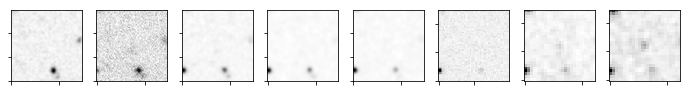

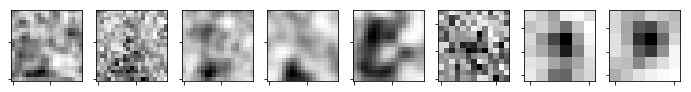

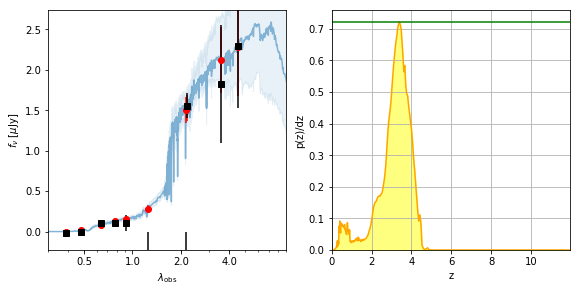

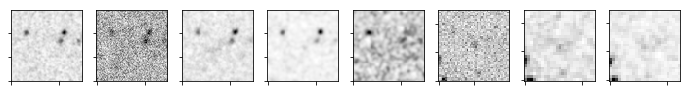

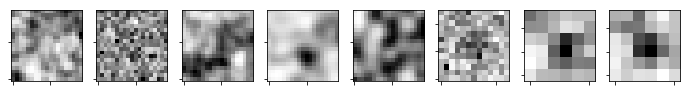

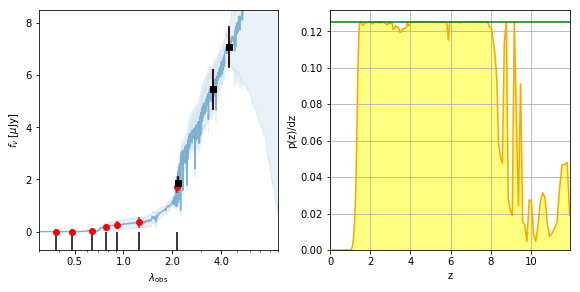

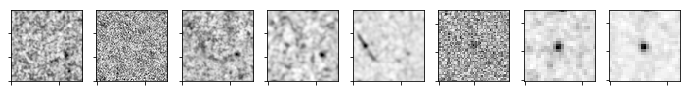

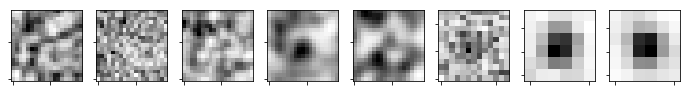

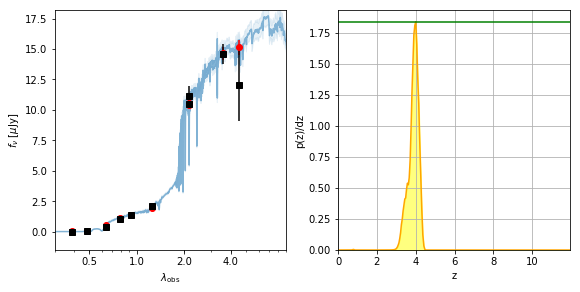

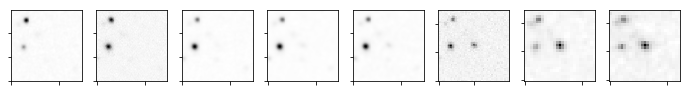

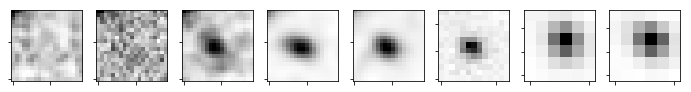

In [66]:
# Show SED
from matplotlib.ticker import NullFormatter
nullfmt = NullFormatter()         # no labels



for id_i in ez.cat['id'][mask_inspect][0:10]:
    print(id_i)
    fig = ez.show_fit(id_i, show_fnu=1)
    
    ra = nhs['RA'][id_i]
    dec = nhs['DEC'][id_i]   
    
    print(zout_copy[ 'z_phot'][zout_copy['id'] == id_i])
    print(np.log10(zout_copy[ 'mass'][zout_copy['id'] == id_i]))
    print(zout_copy[ 'SFR'][zout_copy['id'] == id_i])
    print(zout_copy[ 'ssfr'][zout_copy['id'] == id_i])

    fig, axes = plt.subplots(1,8,figsize=(12,2))
    fig2, axes2 = plt.subplots(1,8,figsize=(12,2))
    stamp_lens = [30.,20.,5.]

    for ax,ax2, band in zip(axes.flat,axes2.flat, ['u','g','r','i','z','K','ch1','ch2']):
        #llim,hlim = gzr.now(stamps_obj[stamp_len][band].data)
        ax.imshow(stamps_obj[id_i][stamp_lens[1]][band].data,  origin='lower',interpolation='nearest',cmap="Greys") 
        ax.xaxis.set_major_formatter(nullfmt)
        ax.yaxis.set_major_formatter(nullfmt)

        ax2.imshow(stamps_obj[id_i][stamp_lens[2]][band].data,  origin='lower',interpolation='nearest',cmap="Greys") 
        #,clim=(llim,hlim)
        ax2.xaxis.set_major_formatter(nullfmt)
        ax2.yaxis.set_major_formatter(nullfmt)

110440
    z_phot   
-------------
4.45442766821
     mass    
   solMass   
-------------
11.4922742816
     SFR     
 solMass / yr
-------------
1.21785554592
       ssfr      
-----------------
3.92031980524e-12
110474
    z_phot   
-------------
4.25807770508
     mass    
   solMass   
-------------
11.6674129211
     SFR     
 solMass / yr
-------------
1.70895375705
       ssfr      
-----------------
3.67550815063e-12
110885
    z_phot   
-------------
4.30526310716
     mass    
   solMass   
-------------
11.5185950357
     SFR     
 solMass / yr
-------------
1.25793044807
       ssfr      
-----------------
3.81119871718e-12
111666
    z_phot   
-------------
3.54230431318
     mass    
   solMass   
-------------
10.9894227601
     SFR     
 solMass / yr
-------------
0.23519485949
       ssfr      
-----------------
2.40993353652e-12
112194
    z_phot   
-------------
3.71704663592
     mass    
   solMass   
-------------
10.7678528592
     SFR     
 solMass / yr
-------

/work/03565/stevans/maverick/software/anaconda3/envs/eazypy/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


113172
    z_phot   
-------------
4.36274657756
     mass    
   solMass   
-------------
11.3310469325
     SFR     
 solMass / yr
-------------
1.28854661893
       ssfr      
-----------------
6.01247388727e-12
113999
    z_phot   
-------------
4.29785575158
     mass    
   solMass   
-------------
11.1662982835
     SFR     
 solMass / yr
-------------
1.13414841914
       ssfr      
-----------------
7.73342019711e-12
114051
    z_phot   
-------------
4.95045229794
     mass    
   solMass   
-------------
11.1694647593
     SFR     
 solMass / yr
-------------
1.04839850699
       ssfr      
-----------------
7.09678477498e-12


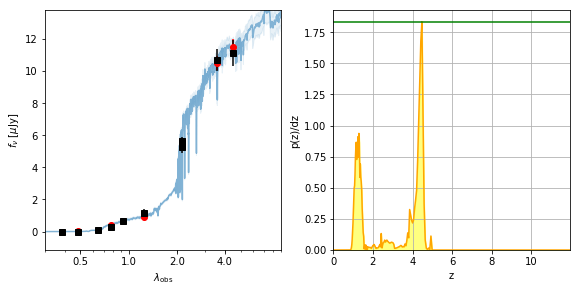

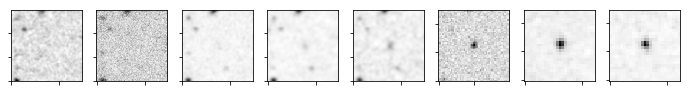

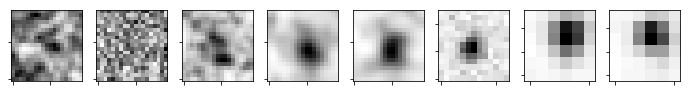

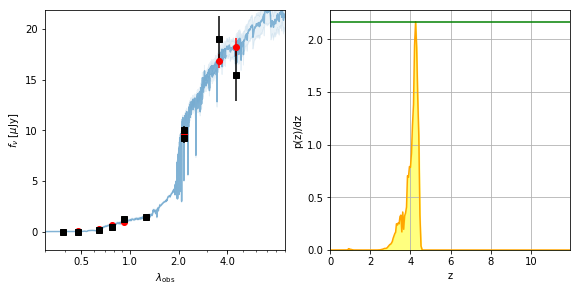

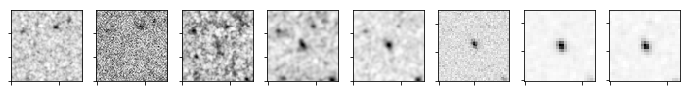

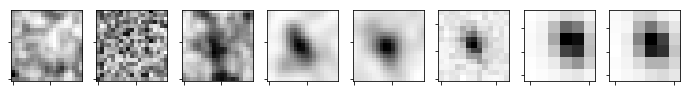

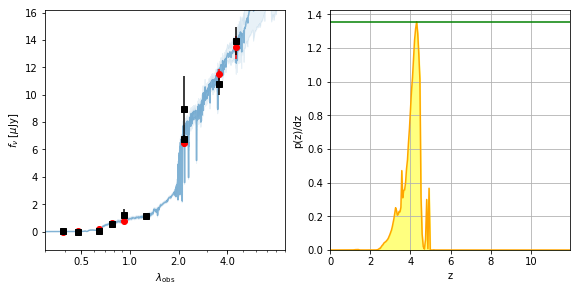

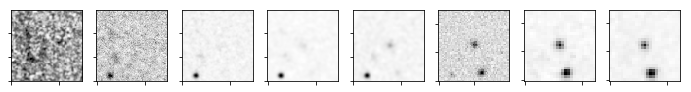

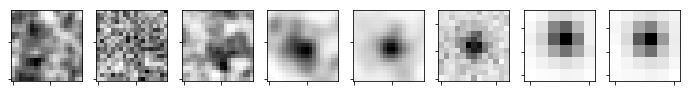

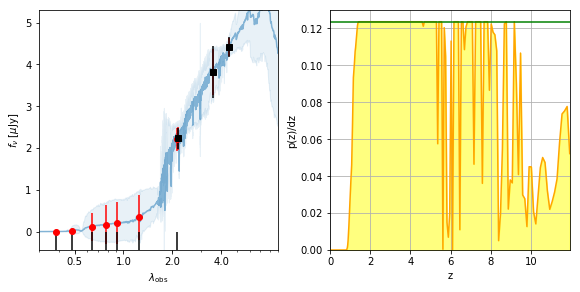

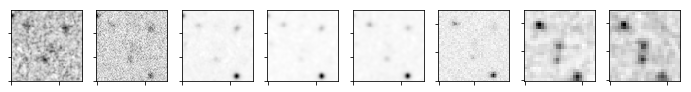

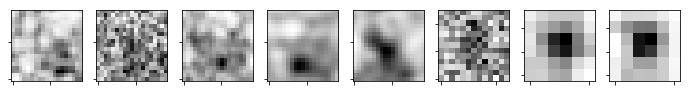

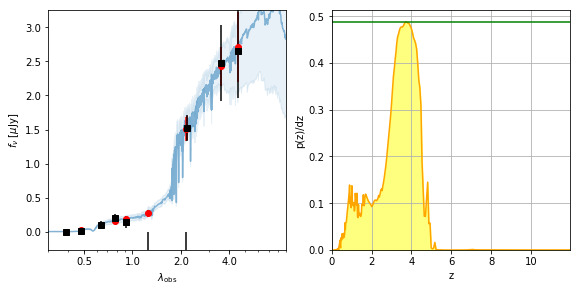

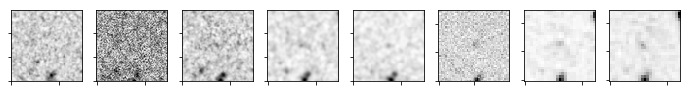

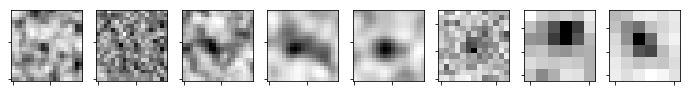

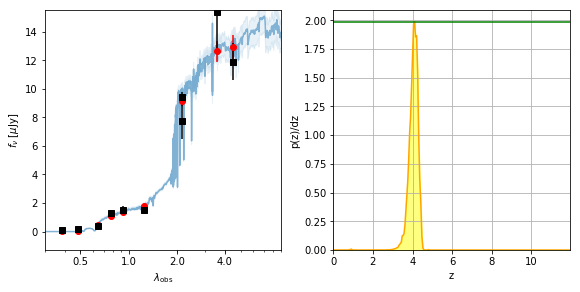

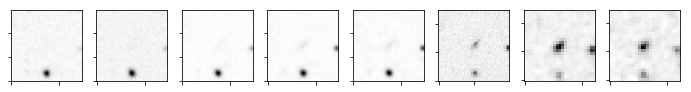

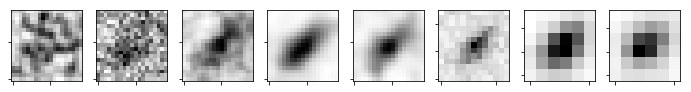

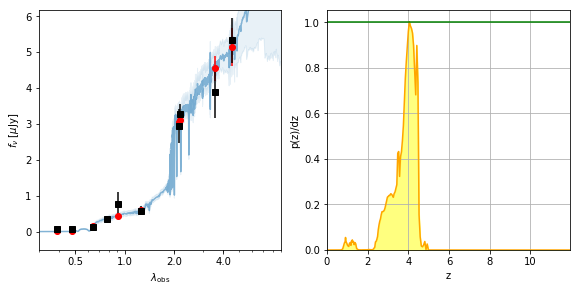

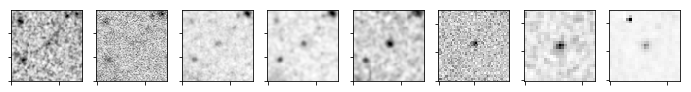

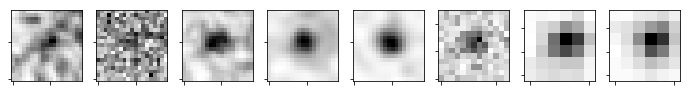

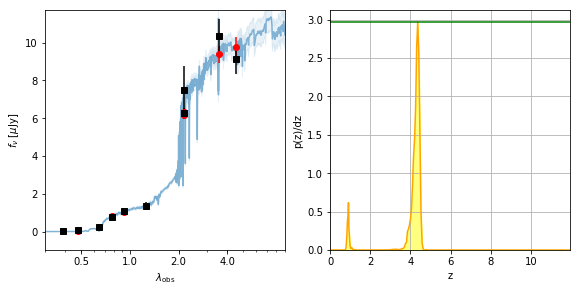

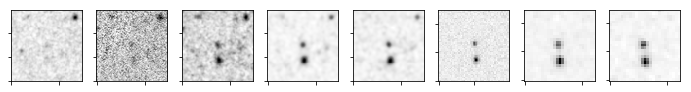

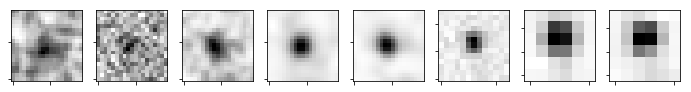

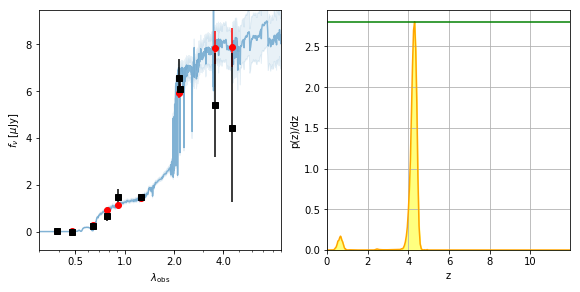

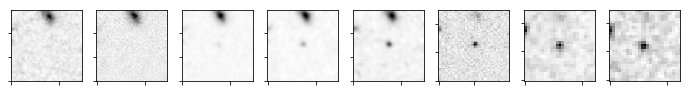

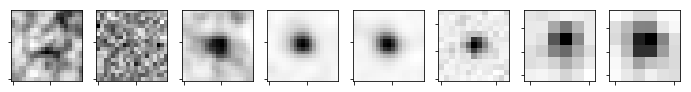

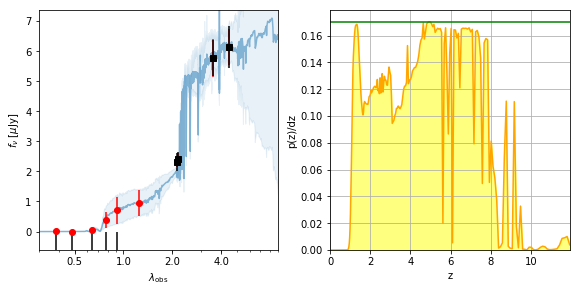

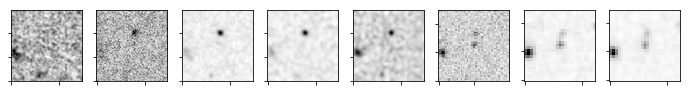

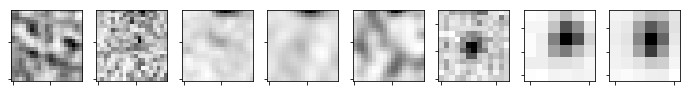

In [67]:
# Show SED
from matplotlib.ticker import NullFormatter
nullfmt = NullFormatter()         # no labels



for id_i in ez.cat['id'][mask_inspect][10:20]:
    print(id_i)
    fig = ez.show_fit(id_i, show_fnu=1)
    
    ra = nhs['RA'][id_i]
    dec = nhs['DEC'][id_i]   
    
    print(zout_copy[ 'z_phot'][zout_copy['id'] == id_i])
    print(np.log10(zout_copy[ 'mass'][zout_copy['id'] == id_i]))
    print(zout_copy[ 'SFR'][zout_copy['id'] == id_i])
    print(zout_copy[ 'ssfr'][zout_copy['id'] == id_i])

    fig, axes = plt.subplots(1,8,figsize=(12,2))
    fig2, axes2 = plt.subplots(1,8,figsize=(12,2))
    stamp_lens = [30.,20.,5.]

    for ax,ax2, band in zip(axes.flat,axes2.flat, ['u','g','r','i','z','K','ch1','ch2']):
        #llim,hlim = gzr.now(stamps_obj[stamp_len][band].data)
        ax.imshow(stamps_obj[id_i][stamp_lens[1]][band].data,  origin='lower',interpolation='nearest',cmap="Greys") 
        ax.xaxis.set_major_formatter(nullfmt)
        ax.yaxis.set_major_formatter(nullfmt)

        ax2.imshow(stamps_obj[id_i][stamp_lens[2]][band].data,  origin='lower',interpolation='nearest',cmap="Greys") 
        #,clim=(llim,hlim)
        ax2.xaxis.set_major_formatter(nullfmt)
        ax2.yaxis.set_major_formatter(nullfmt)

114310
    z_phot   
-------------
3.15770330138
     mass    
   solMass   
-------------
10.9273895776
     SFR      
 solMass / yr 
--------------
0.556123920061
       ssfr      
-----------------
6.57327796535e-12
114825
    z_phot   
-------------
4.31106138178
     mass    
   solMass   
-------------
11.3972050542
     SFR     
 solMass / yr
-------------
1.57864495237
       ssfr      
-----------------
6.32527499033e-12
114850
   z_phot   
------------
4.0175817981
     mass    
   solMass   
-------------
10.8830036832
     SFR      
 solMass / yr 
--------------
0.529558203865
       ssfr      
-----------------
6.93282147936e-12
115213
    z_phot   
-------------
3.25602997379
     mass    
   solMass   
-------------
11.2520420939
     SFR      
 solMass / yr 
--------------
0.517594130762
       ssfr      
-----------------
2.89699168767e-12
115237
    z_phot   
-------------
4.33953598705
     mass    
   solMass   
-------------
11.1351384781
     SFR      
 solMass / 

/work/03565/stevans/maverick/software/anaconda3/envs/eazypy/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


117758
    z_phot   
-------------
4.29820473821
     mass    
   solMass   
-------------
11.3667632926
     SFR     
 solMass / yr
-------------
1.28095881272
       ssfr      
-----------------
5.50518443484e-12
118142
    z_phot   
-------------
4.05198374293
     mass    
   solMass   
-------------
11.3768326022
    SFR     
solMass / yr
------------
1.2475851407
      ssfr      
----------------
5.2388696317e-12
118441
    z_phot   
-------------
4.16590995238
     mass    
   solMass   
-------------
11.1985236996
     SFR      
 solMass / yr 
--------------
0.964201801834
       ssfr      
-----------------
6.10441764653e-12


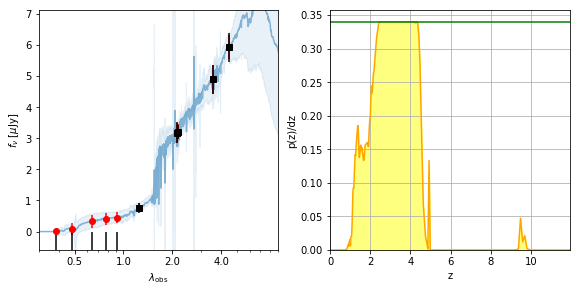

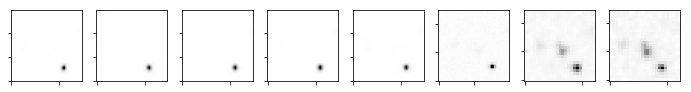

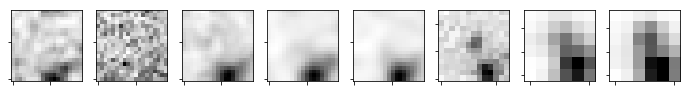

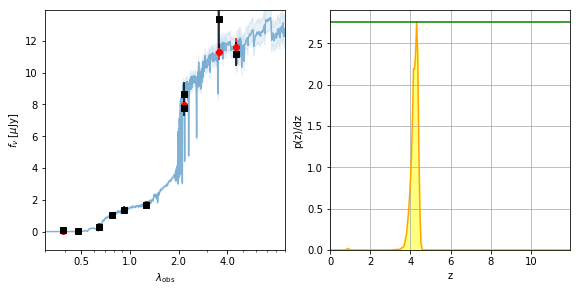

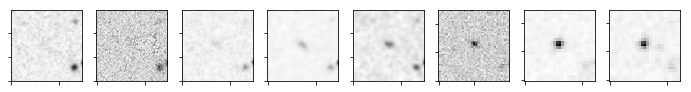

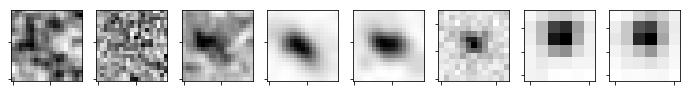

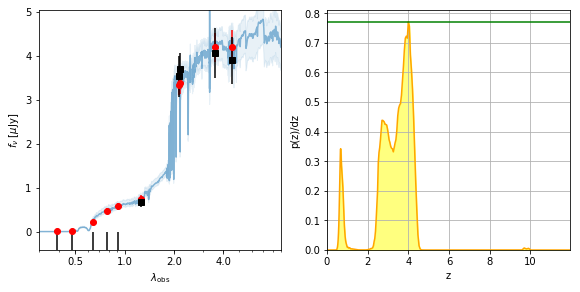

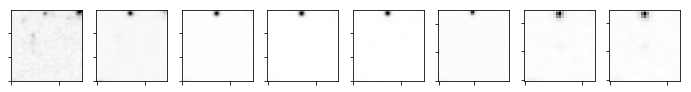

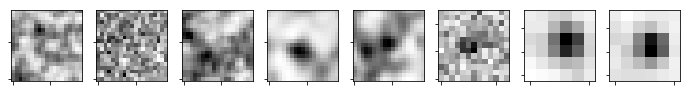

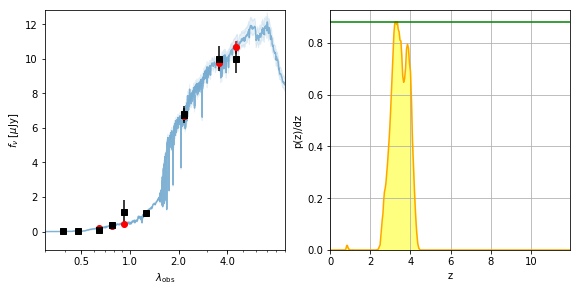

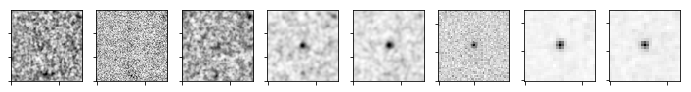

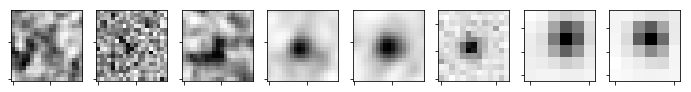

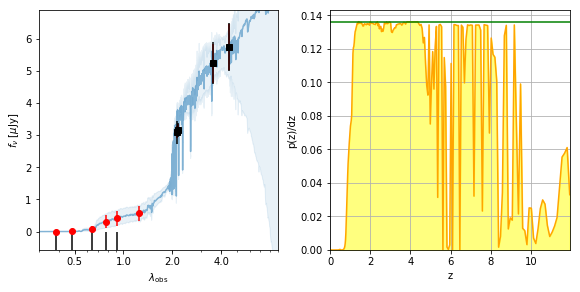

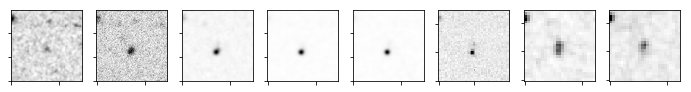

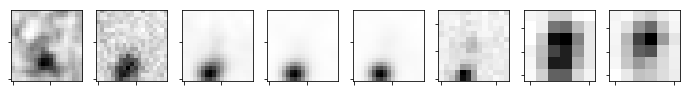

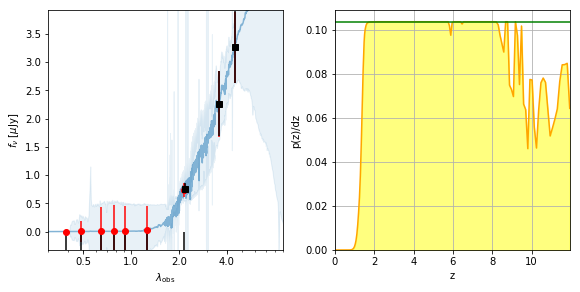

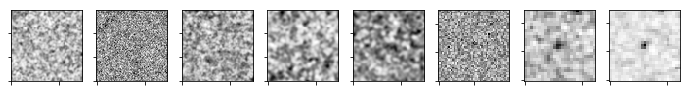

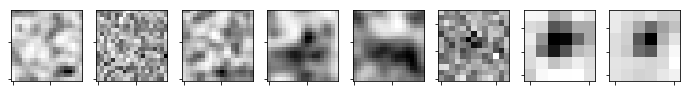

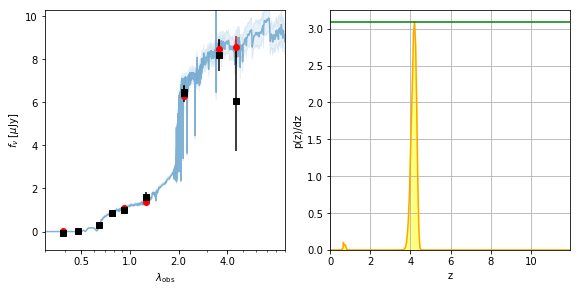

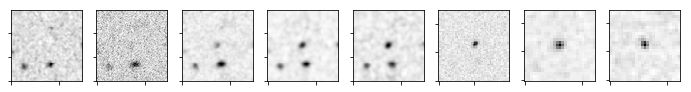

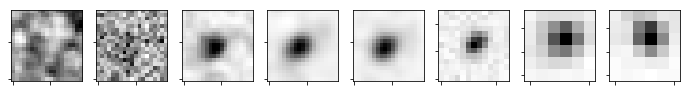

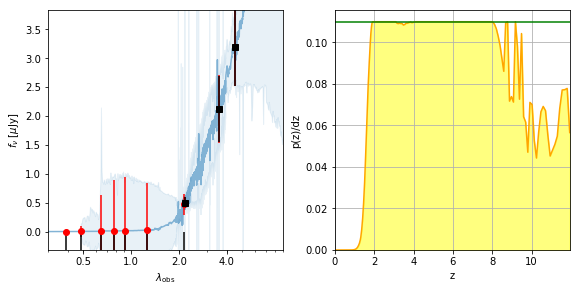

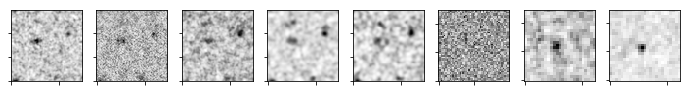

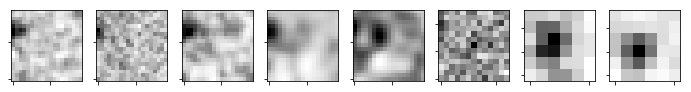

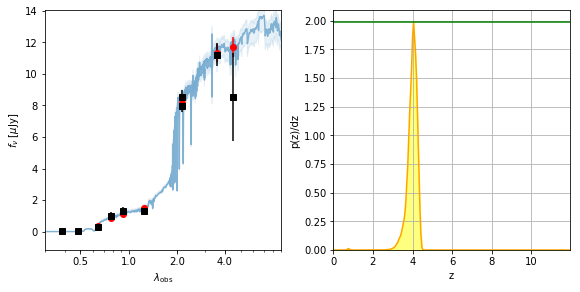

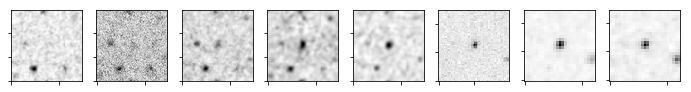

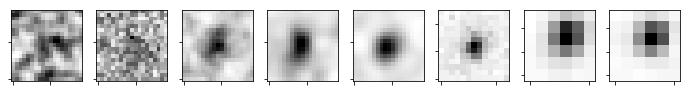

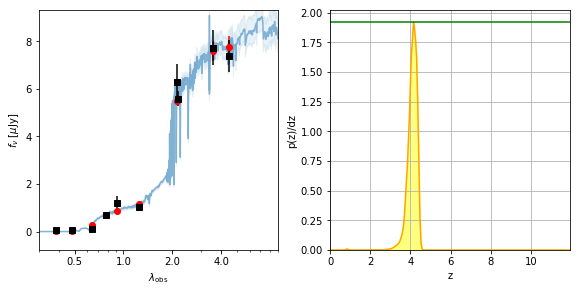

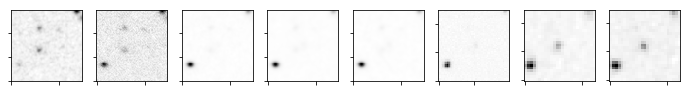

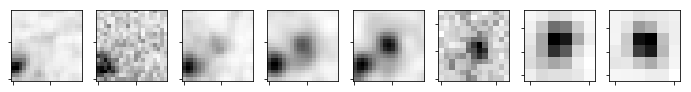

In [68]:
# Show SED
from matplotlib.ticker import NullFormatter
nullfmt = NullFormatter()         # no labels



for id_i in ez.cat['id'][mask_inspect][20:30]:
    print(id_i)
    fig = ez.show_fit(id_i, show_fnu=1)
    
    ra = nhs['RA'][id_i]
    dec = nhs['DEC'][id_i]   
    
    print(zout_copy[ 'z_phot'][zout_copy['id'] == id_i])
    print(np.log10(zout_copy[ 'mass'][zout_copy['id'] == id_i]))
    print(zout_copy[ 'SFR'][zout_copy['id'] == id_i])
    print(zout_copy[ 'ssfr'][zout_copy['id'] == id_i])

    fig, axes = plt.subplots(1,8,figsize=(12,2))
    fig2, axes2 = plt.subplots(1,8,figsize=(12,2))
    stamp_lens = [30.,20.,5.]

    for ax,ax2, band in zip(axes.flat,axes2.flat, ['u','g','r','i','z','K','ch1','ch2']):
        #llim,hlim = gzr.now(stamps_obj[stamp_len][band].data)
        ax.imshow(stamps_obj[id_i][stamp_lens[1]][band].data,  origin='lower',interpolation='nearest',cmap="Greys") 
        ax.xaxis.set_major_formatter(nullfmt)
        ax.yaxis.set_major_formatter(nullfmt)

        ax2.imshow(stamps_obj[id_i][stamp_lens[2]][band].data,  origin='lower',interpolation='nearest',cmap="Greys") 
        #,clim=(llim,hlim)
        ax2.xaxis.set_major_formatter(nullfmt)
        ax2.yaxis.set_major_formatter(nullfmt)

110440
110474
110885
111666
112194
112294
112920


/work/03565/stevans/maverick/software/anaconda3/envs/eazypy/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


113172
113999
114051


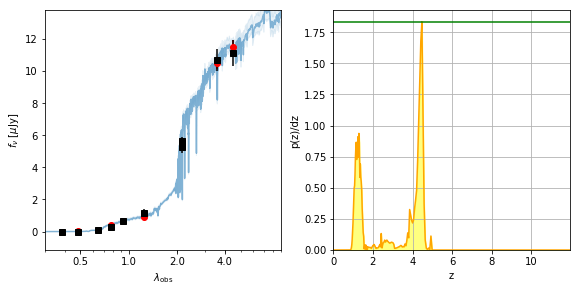

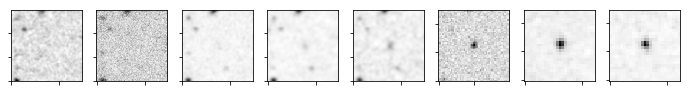

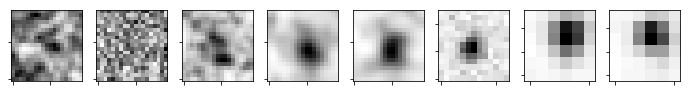

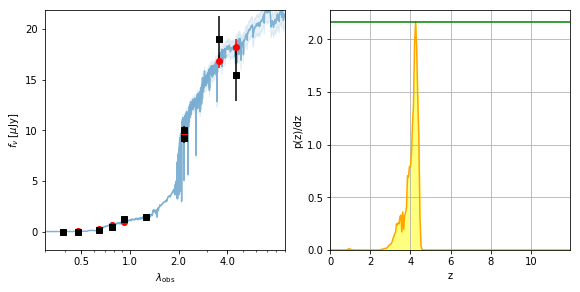

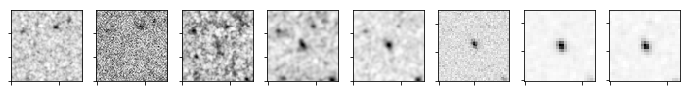

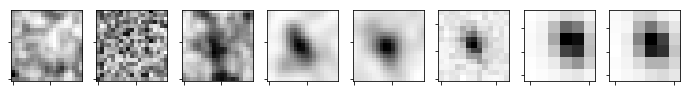

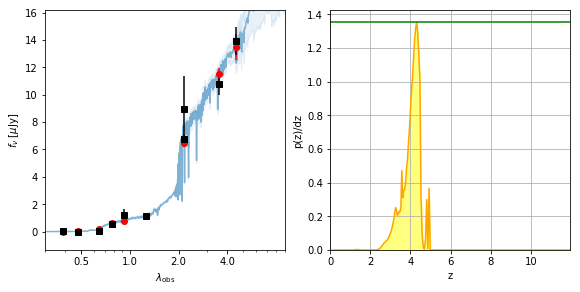

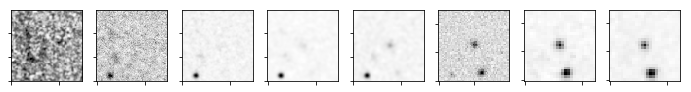

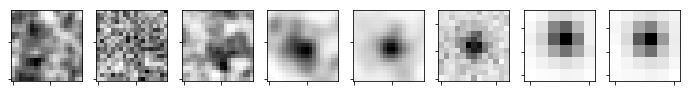

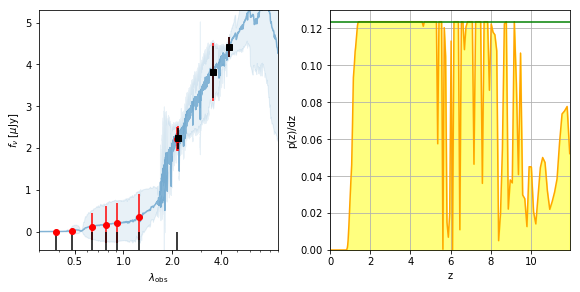

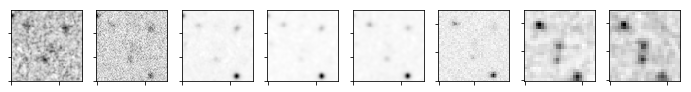

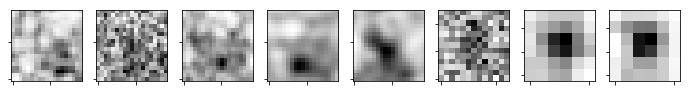

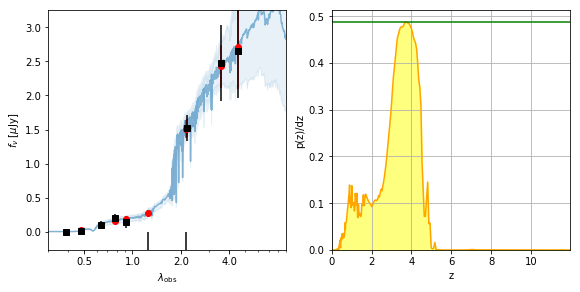

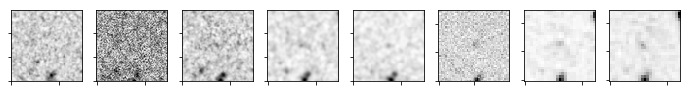

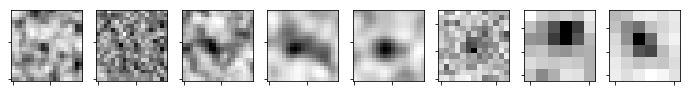

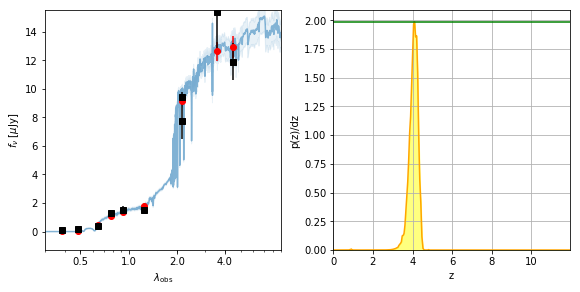

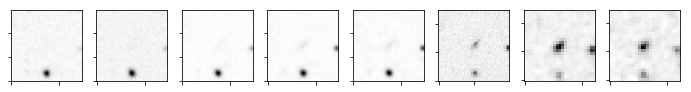

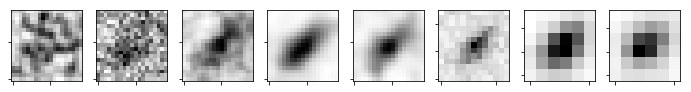

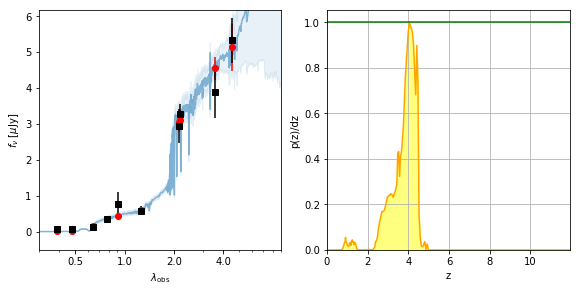

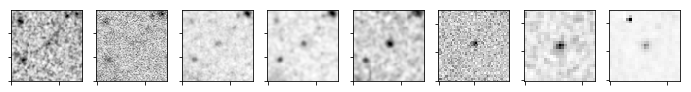

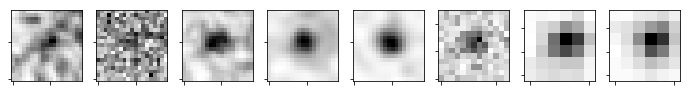

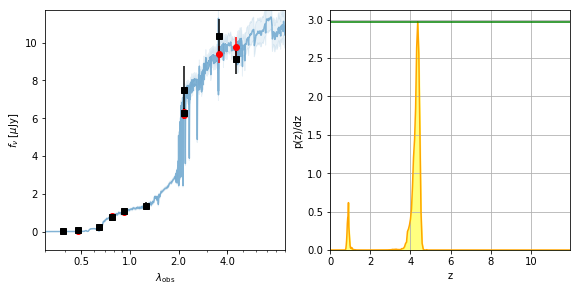

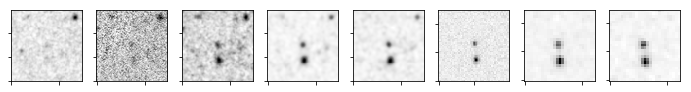

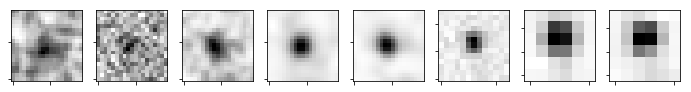

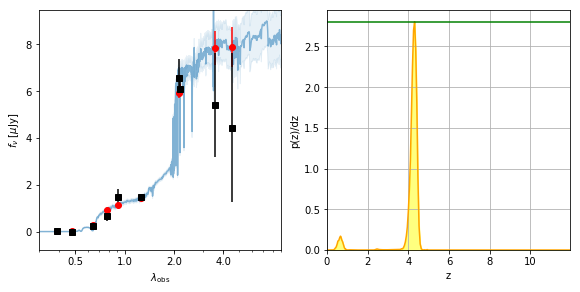

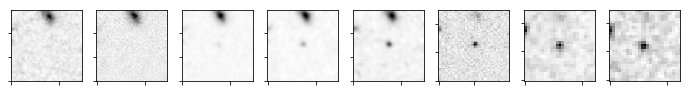

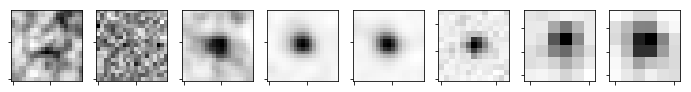

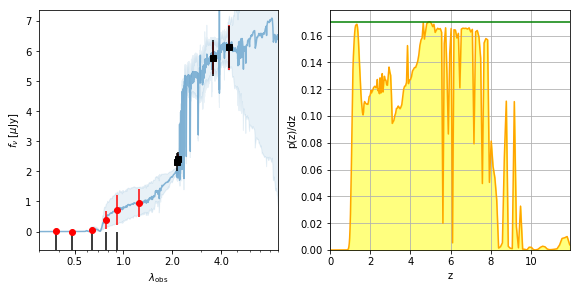

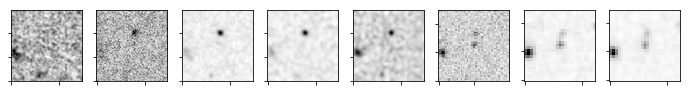

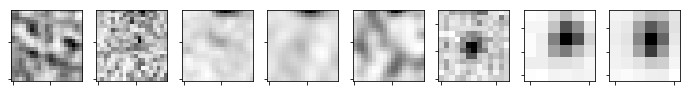

In [51]:
# Show SED
from matplotlib.ticker import NullFormatter
nullfmt = NullFormatter()         # no labels



for id_i in ez.cat['id'][mask_inspect][10:20]:
    print(id_i)
    fig = ez.show_fit(id_i, show_fnu=1)
    
    ra = nhs['RA'][id_i]
    dec = nhs['DEC'][id_i]    
    fig, axes = plt.subplots(1,8,figsize=(12,2))
    fig2, axes2 = plt.subplots(1,8,figsize=(12,2))
    stamp_lens = [30.,20.,5.]

    for ax,ax2, band in zip(axes.flat,axes2.flat, ['u','g','r','i','z','K','ch1','ch2']):
        #llim,hlim = gzr.now(stamps_obj[stamp_len][band].data)
        ax.imshow(stamps_obj[id_i][stamp_lens[1]][band].data,  origin='lower',interpolation='nearest',cmap="Greys") 
        ax.xaxis.set_major_formatter(nullfmt)
        ax.yaxis.set_major_formatter(nullfmt)

        ax2.imshow(stamps_obj[id_i][stamp_lens[2]][band].data,  origin='lower',interpolation='nearest',cmap="Greys") 
        #,clim=(llim,hlim)
        ax2.xaxis.set_major_formatter(nullfmt)
        ax2.yaxis.set_major_formatter(nullfmt)

114310
114825
114850
115213
115237
115789
116406


/work/03565/stevans/maverick/software/anaconda3/envs/eazypy/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


117758
118142
118441


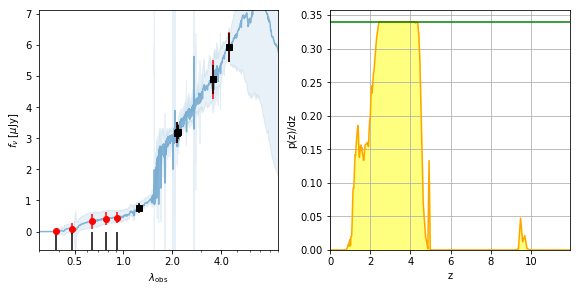

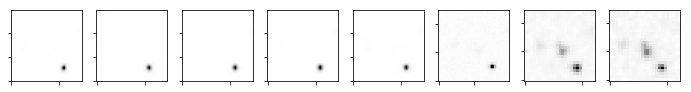

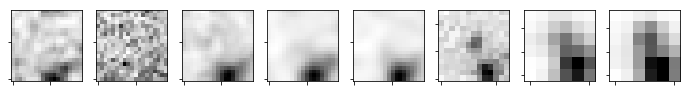

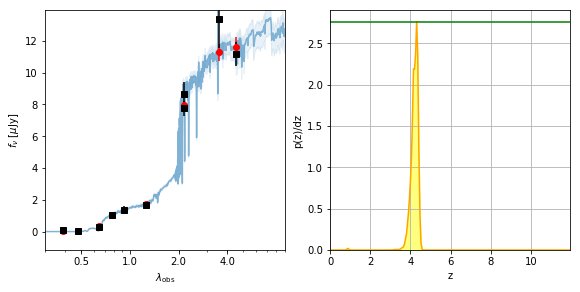

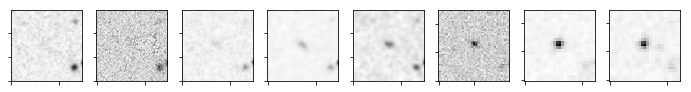

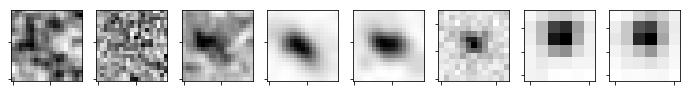

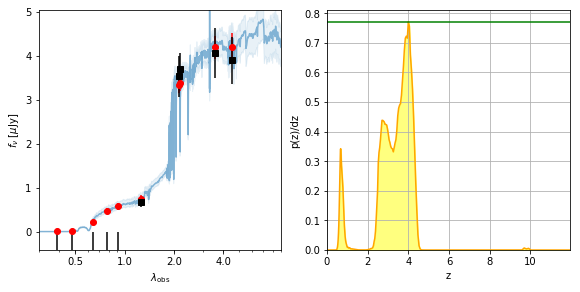

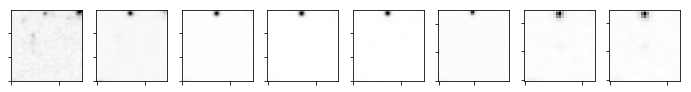

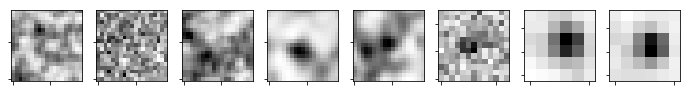

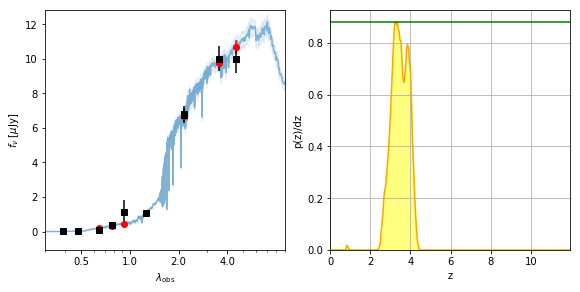

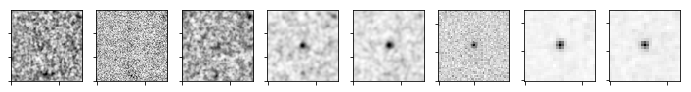

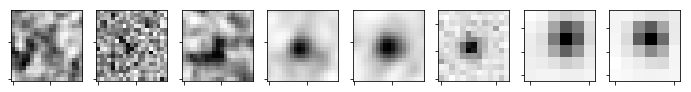

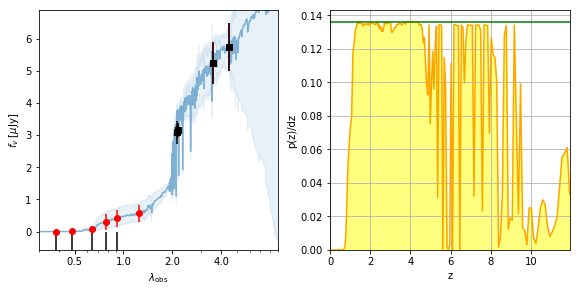

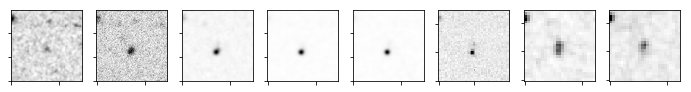

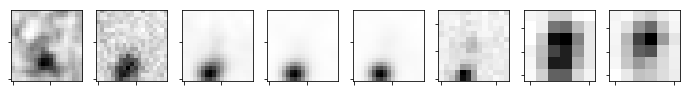

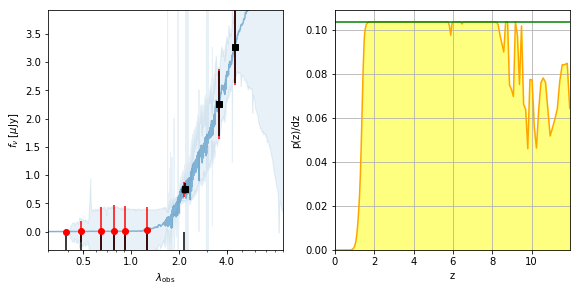

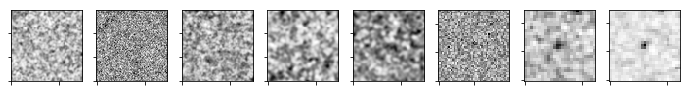

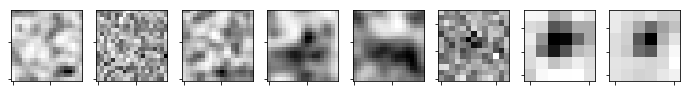

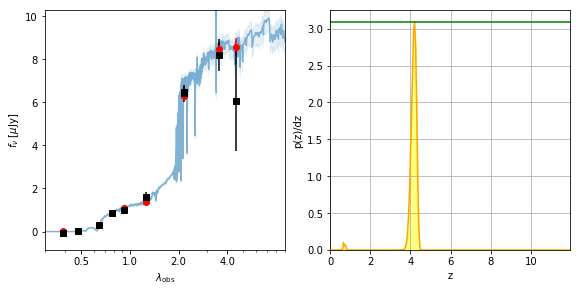

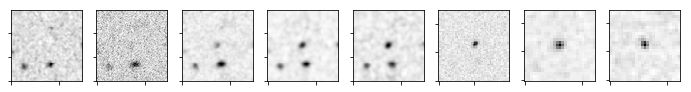

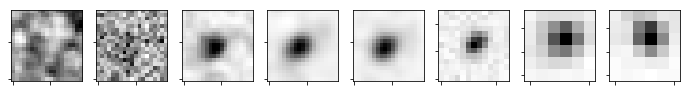

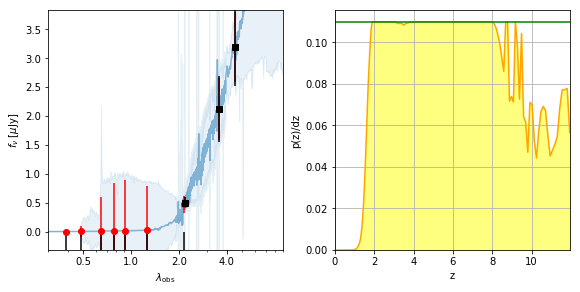

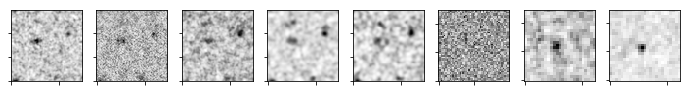

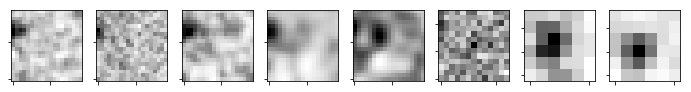

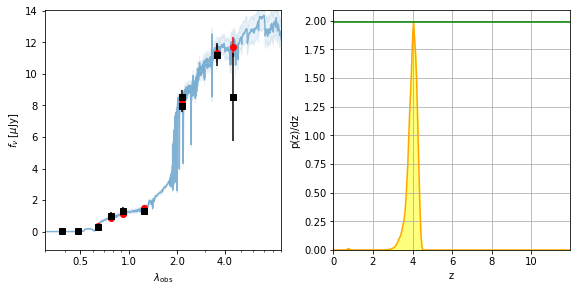

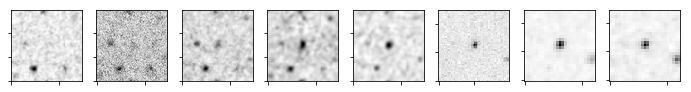

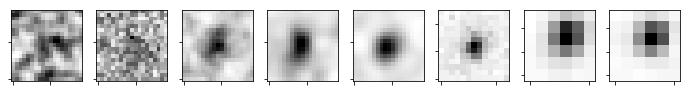

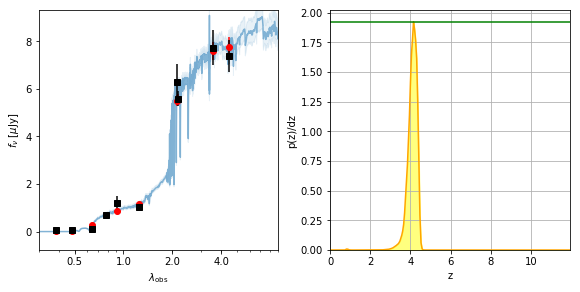

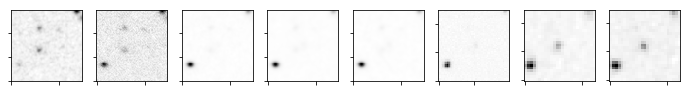

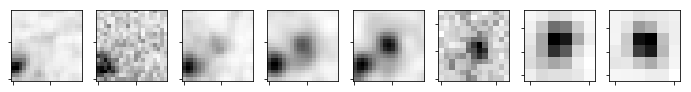

In [52]:
# Show SED
from matplotlib.ticker import NullFormatter
nullfmt = NullFormatter()         # no labels



for id_i in ez.cat['id'][mask_inspect][20:30]:
    print(id_i)
    fig = ez.show_fit(id_i, show_fnu=1)
    
    ra = nhs['RA'][id_i]
    dec = nhs['DEC'][id_i]    
    fig, axes = plt.subplots(1,8,figsize=(12,2))
    fig2, axes2 = plt.subplots(1,8,figsize=(12,2))
    stamp_lens = [30.,20.,5.]

    for ax,ax2, band in zip(axes.flat,axes2.flat, ['u','g','r','i','z','K','ch1','ch2']):
        #llim,hlim = gzr.now(stamps_obj[stamp_len][band].data)
        ax.imshow(stamps_obj[id_i][stamp_lens[1]][band].data,  origin='lower',interpolation='nearest',cmap="Greys") 
        ax.xaxis.set_major_formatter(nullfmt)
        ax.yaxis.set_major_formatter(nullfmt)

        ax2.imshow(stamps_obj[id_i][stamp_lens[2]][band].data,  origin='lower',interpolation='nearest',cmap="Greys") 
        #,clim=(llim,hlim)
        ax2.xaxis.set_major_formatter(nullfmt)
        ax2.yaxis.set_major_formatter(nullfmt)

In [55]:
print(cat_new['NUMBER'][mask_inspect][0])
print(nhs['NUMBER'][107488])
print(nhs['RA'][107488])


107488
107488
15.3945342864


In [29]:
# print VISTA S/N and Flux
for fj,ej in zip( ez.cat['flux_J_vista'][mask_inspect],ez.cat['err_J_vista'][mask_inspect]):
    print(fj,fj/ej)

-99.0 1.0
3.17794444806 6.62980604172
0.925474465837 3.92002940178
-99.0 1.0
-99.0 1.0
-99.0 1.0
-99.0 1.0
1.1710232592 4.62065982819
-99.0 1.0
1.66690269139 4.94254732132
1.89219987953 5.90610837936
-99.0 1.0
-99.0 1.0
-99.0 1.0
1.80734290214 4.36017179489
-99.0 1.0
1.37198172846 4.37339019775
1.44543977075e+49 -99.0
1.44543977075e+49 -99.0
2.10451639409 5.07141494751
1.00186774387 3.80518913269
1.44543977075e+49 -99.0
1.83863702862 6.29121923447
1.0528518111 5.81490421295
2.97803466365 8.27324295044
1.44543977075e+49 -99.0
-99.0 1.0
2.0572592892 5.02552270889
1.56166965793 5.29363441467
-99.0 1.0
-99.0 1.0
2.89183935556 7.17390108109
-99.0 1.0
1.76838595468 7.31269645691
1.78808811285 5.4557299614
-99.0 1.0
-99.0 1.0
1.24016671769 4.36812496185
2.7031279784 5.87346410751
-99.0 1.0
1.64867773413 6.70956897736
1.61286309136 5.84206581116
-99.0 1.0
3.84658674745 5.90276670456
-99.0 1.0
-99.0 1.0
1.17477330983 5.46851968765
-99.0 1.0


In [36]:
# print VISTA S/N and Flux
for fj,ej in zip( ez.cat['flux_g'][mask_inspect],ez.cat['err_g'][mask_inspect]):
    print(fj,fj/ej)

-99.0 1.0
-99.0 1.0
-99.0 1.0
-39.8474578857 -0.542466705438
363.935394287 2.22288061519
-99.0 1.0
-99.0 1.0
-132.838668823 -1.13797486514
-99.0 1.0
-99.0 1.0
-99.0 1.0
-99.0 1.0
-99.0 1.0
1764.7980957 7.06985258415
-99.0 1.0
-99.0 1.0
50.9780693054 0.526767638011
-99.0 1.0
-99.0 1.0
-99.0 1.0
-99.0 1.0
-99.0 1.0
-99.0 1.0
187.968429565 2.58286939957
152.977294922 1.14385572304
330.140472412 2.71823108222
669.433166504 3.99757005682
3.40565538406 0.048132286155
66.0585098267 0.400700474917
-99.0 1.0
-99.0 1.0
-99.0 1.0
183.56552124 1.29127046638
-99.0 1.0
-99.0 1.0
-99.0 1.0
-99.0 1.0
-99.0 1.0
540.921875 3.47895868489
-99.0 1.0
-99.0 1.0
-99.0 1.0
782.601928711 3.2764285241
308.363952637 3.00281101343


In [41]:
# print VISTA S/N and Flux
for fk,ek,fj,ej in zip( ez.cat['flux_K'][1000:1100],ez.cat['err_K'][1000:1100],ez.cat['flux_g'][1000:1100],ez.cat['err_g'][1000:1100]):
    print(fk,fk/ek,fj,fj/ej)

6.59401614843 9.45048486494 -99.0 1.0
6.98433954126 13.7025787474 -99.0 1.0
25.9327985601 21.435188096 9251.93945312 18.857061136
62.6152071108 50.7311307967 201.570632935 1.48897753716
11.1067313188 16.0056044139 635.592529297 2.75102043122
4.82510677553 7.9153922829 1408.3067627 7.94252861389
7.49600302258 9.89018386283 75.1539916992 0.519940749851
10.553618599 14.5448356942 2064.84375 11.3407229256
3.27518452208 7.99909233659 1341.98046875 9.87875882668
16.4310341364 19.4940096388 385.419128418 2.61441658073
4.37942270454 8.72569990917 2944.48193359 16.3064536567
14969.4195586 10120.9914587 -99.0 1.0
20.3313634974 28.2290754128 7739.82763672 19.6794225267
13.9489352515 15.5844746413 2396.19116211 10.9141962703
1.51805131975 6.31476801244 -66.6226654053 -0.635438196629
9.37505155869 13.484328802 848.436950684 4.46926822745
2.19098668842 5.84051526399 367.825744629 1.77994621256
6.12671938088 9.32708409125 375.272857666 1.87262737638
114.149160151 72.659483483 -99.0 1.0
17.9257280997 

In [ ]:
#plot histogram of sSFR

import sys
# the mock-0.3.1 dir contains testcase.py, testutils.py & mock.py
sys.path.append('/work/03565/stevans/maverick/my_projects/decam/code')
import histo_ms as hm


In [23]:
data_to_plot = np.log10(zout_copy['ssfr'])

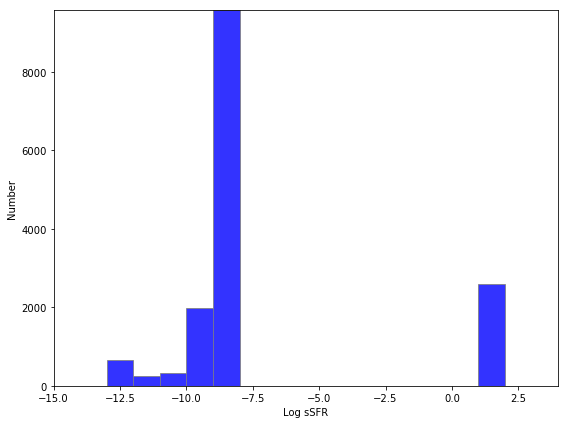

ax Axes(0.0994792,0.0967593;0.875694x0.870139) False


In [24]:
n, bins, ax = hm.now(data_to_plot,bin_step=1,bin_min = -15, bin_max = 4, \
                     return_ax=True, ylog=False, \
plot_title = '', xlabel = 'Log sSFR')


In [14]:
#make sSFR mask
mask_ssfr = np.log10(zout_copy['ssfr']) < -11